# Explainable AI (XAI)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [55]:
#to find the best set of parameter setting, we can run a grid search
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import shap
import pickle

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from tqdm import tqdm

from interpret.blackbox import LimeTabular

from xailib.explainers.lore_explainer import LoreTabularExplainer

In [47]:
RANDOM_STATE = 42
dev_set = pd.read_csv('../data/ml_datasets/undersampling/dev_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # shuffling the data so not to introduce bias
test_set = pd.read_csv('../data/ml_datasets/undersampling/test_set.csv')

In [48]:
dev_set['race_season%autumn'] = dev_set['race_season%autumn'].astype(int)
dev_set['race_season%spring'] = dev_set['race_season%spring'].astype(int)
dev_set['race_season%summer'] = dev_set['race_season%summer'].astype(int)
dev_set['race_season%winter'] = dev_set['race_season%winter'].astype(int)

test_set['race_season%autumn'] = test_set['race_season%autumn'].astype(int)
test_set['race_season%spring'] = test_set['race_season%spring'].astype(int)
test_set['race_season%summer'] = test_set['race_season%summer'].astype(int)
test_set['race_season%winter'] = test_set['race_season%winter'].astype(int)

In [49]:
dev_label = dev_set.pop('label')
test_label = test_set.pop('label')

In [11]:
RANDOM_STATE = 42
RUS = RandomUnderSampler(random_state=RANDOM_STATE)
dev_set, dev_label = RUS.fit_resample(dev_set, dev_label)

In [12]:
model = XGBClassifier(n_estimators=200, max_depth=13, learning_rate=0.108715)
model.fit(dev_set, dev_label)

test_predicitions = model.predict(test_set)
dev_predictions = model.predict(dev_set)

In [13]:
report = classification_report(test_label, test_predicitions, output_dict=True)

In [14]:
perturbation_data = dev_set
perturbation_labels = dev_label
perturbation_predictions = dev_predictions

explanation_data = test_set
explanation_labels = test_label
explanation_predictions = test_predicitions

explanations = dict()

## Shap


In [15]:
interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=dev_set,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

In [16]:
# interventional_explanations = interventional_explanation_algorithm(explanation_data)
# distributional_explanations = distributional_explanation_algorithm(explanation_data)

# with open('under_interventional_explanations.pkl', 'wb') as f:
#     pickle.dump(interventional_explanations, f)

# with open('under_distributional_explanations.pkl', 'wb') as f:
#     pickle.dump(distributional_explanations, f)

In [17]:
interventional_explanations = pickle.load(open('under_interventional_explanations.pkl', 'rb'))
distributional_explanations = pickle.load(open('under_distributional_explanations.pkl', 'rb'))

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

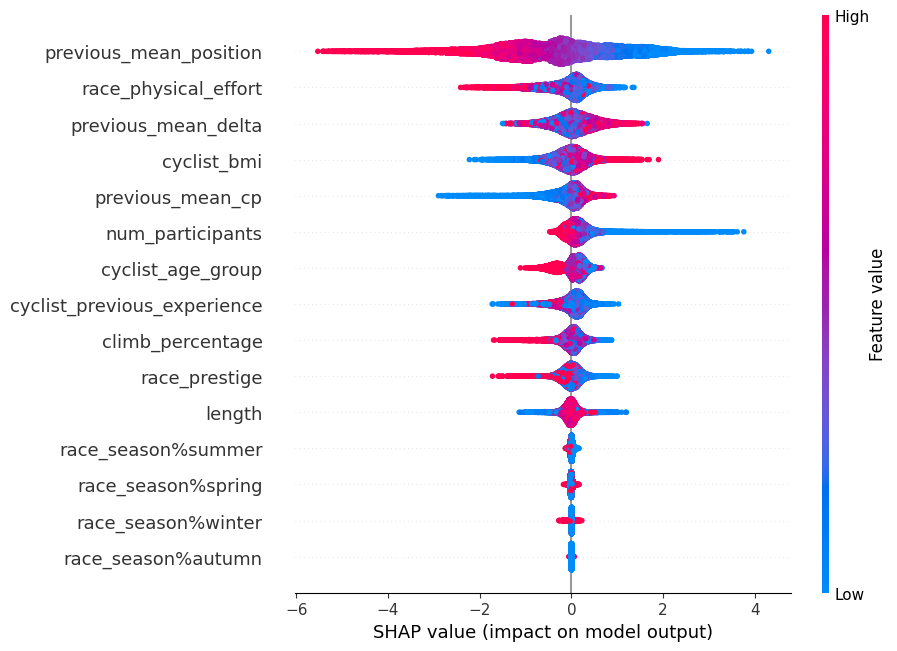

In [18]:
shap.plots.beeswarm(interventional_explanations, max_display=20)

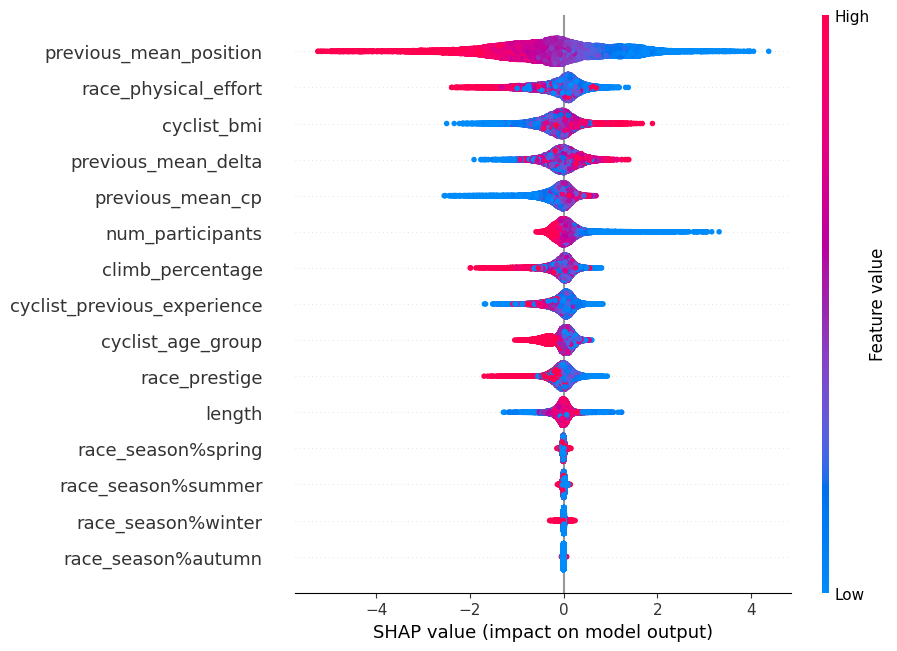

In [19]:
shap.plots.beeswarm(distributional_explanations, max_display=20)

In [20]:
explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

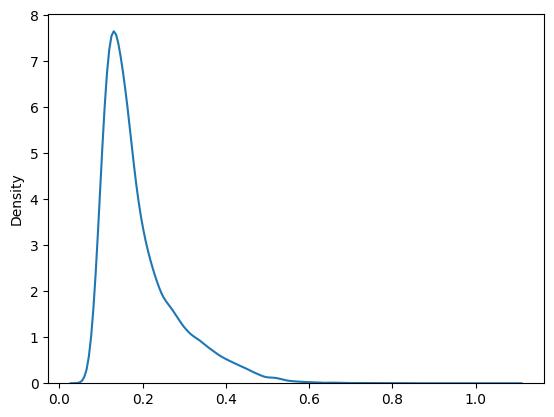

In [21]:
sb.kdeplot(maximum_differences_per_instance)

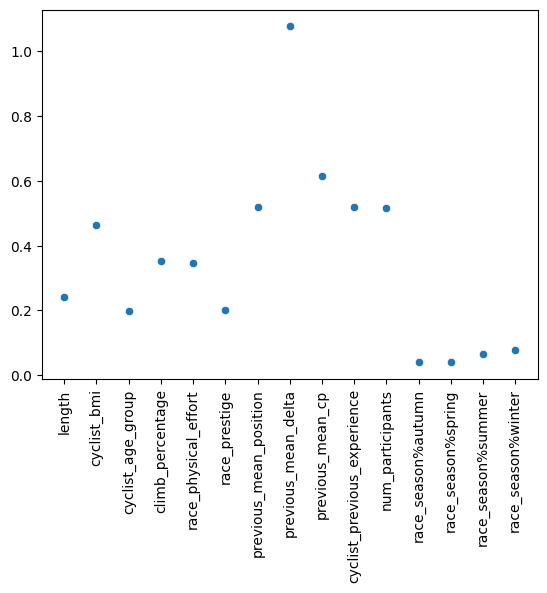

In [22]:
sb.scatterplot(x=dev_set.columns.tolist(), y=maximum_differences_per_feature)
plt.xticks(rotation=90);

In [23]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=dev_set.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,length,cyclist_bmi,cyclist_age_group,climb_percentage,race_physical_effort,race_prestige,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,race_season%autumn,race_season%spring,race_season%summer,race_season%winter
mean,-0.015385,-0.045188,0.018068,-0.019140,-0.097492,-0.007720,-0.325641,0.063626,-0.072111,0.017025,0.148207,0.000051,-0.000834,0.005772,-0.004339
std,0.153649,0.390317,0.262484,0.260035,0.455407,0.192327,1.325555,0.409540,0.365262,0.265116,0.311244,0.001869,0.024602,0.028990,0.028130
min,-1.138783,-2.225408,-1.111664,-1.698295,-2.417540,-1.721616,-5.532534,-1.501584,-2.900923,-1.728625,-0.472538,-0.058207,-0.174130,-0.133052,-0.277323
25%,-0.092216,-0.243649,-0.136092,-0.108678,-0.303659,-0.121337,-1.183478,-0.190144,-0.221574,-0.106012,-0.028484,-0.000878,-0.014831,-0.013043,-0.007577
50%,-0.013758,-0.017148,0.076075,0.020156,0.014769,-0.002880,-0.295679,0.054876,-0.000031,0.065099,0.107626,0.000094,-0.002996,0.004169,0.002117
75%,0.061597,0.180209,0.207167,0.126867,0.192175,0.112115,0.562836,0.323101,0.145484,0.186006,0.253638,0.000983,0.011296,0.022594,0.008071
max,1.199083,1.900379,0.671361,0.879991,1.365107,0.998561,4.305218,1.653914,0.931475,1.029751,3.761463,0.064165,0.164436,0.161714,0.228295


In [24]:
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=dev_set.columns.tolist())
distributional_explanations_df.describe().drop("count", axis="rows")

,length,cyclist_bmi,cyclist_age_group,climb_percentage,race_physical_effort,race_prestige,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,race_season%autumn,race_season%spring,race_season%summer,race_season%winter
mean,-0.028943,-0.128709,-0.037221,-0.056744,-0.091887,-0.021781,-0.248712,-0.003473,-0.121031,-0.039536,0.058158,-0.002825,-0.001694,0.003552,-0.005119
std,0.159718,0.386063,0.230626,0.269200,0.458360,0.190649,1.203656,0.313334,0.300248,0.247180,0.286863,0.003690,0.024346,0.022555,0.028572
min,-1.288122,-2.499875,-1.045175,-1.997653,-2.395134,-1.699790,-5.253061,-1.915188,-2.552077,-1.694180,-0.590825,-0.047078,-0.143479,-0.134475,-0.300802
25%,-0.098906,-0.319617,-0.153015,-0.149409,-0.303146,-0.134667,-1.001234,-0.188977,-0.241627,-0.154682,-0.105372,-0.003619,-0.015697,-0.009661,-0.009561
50%,-0.016590,-0.097014,0.012767,-0.005339,0.014812,-0.017430,-0.237361,-0.007085,-0.066871,0.007346,0.021407,-0.001887,-0.003690,0.003595,0.001791
75%,0.051479,0.087062,0.121435,0.100478,0.193494,0.093452,0.517158,0.189887,0.062860,0.117580,0.159193,-0.000909,0.010828,0.016671,0.008116
max,1.239994,1.897270,0.602804,0.808017,1.381453,0.932975,4.381815,1.392694,0.694123,0.841694,3.322267,0.062527,0.156503,0.143491,0.245355


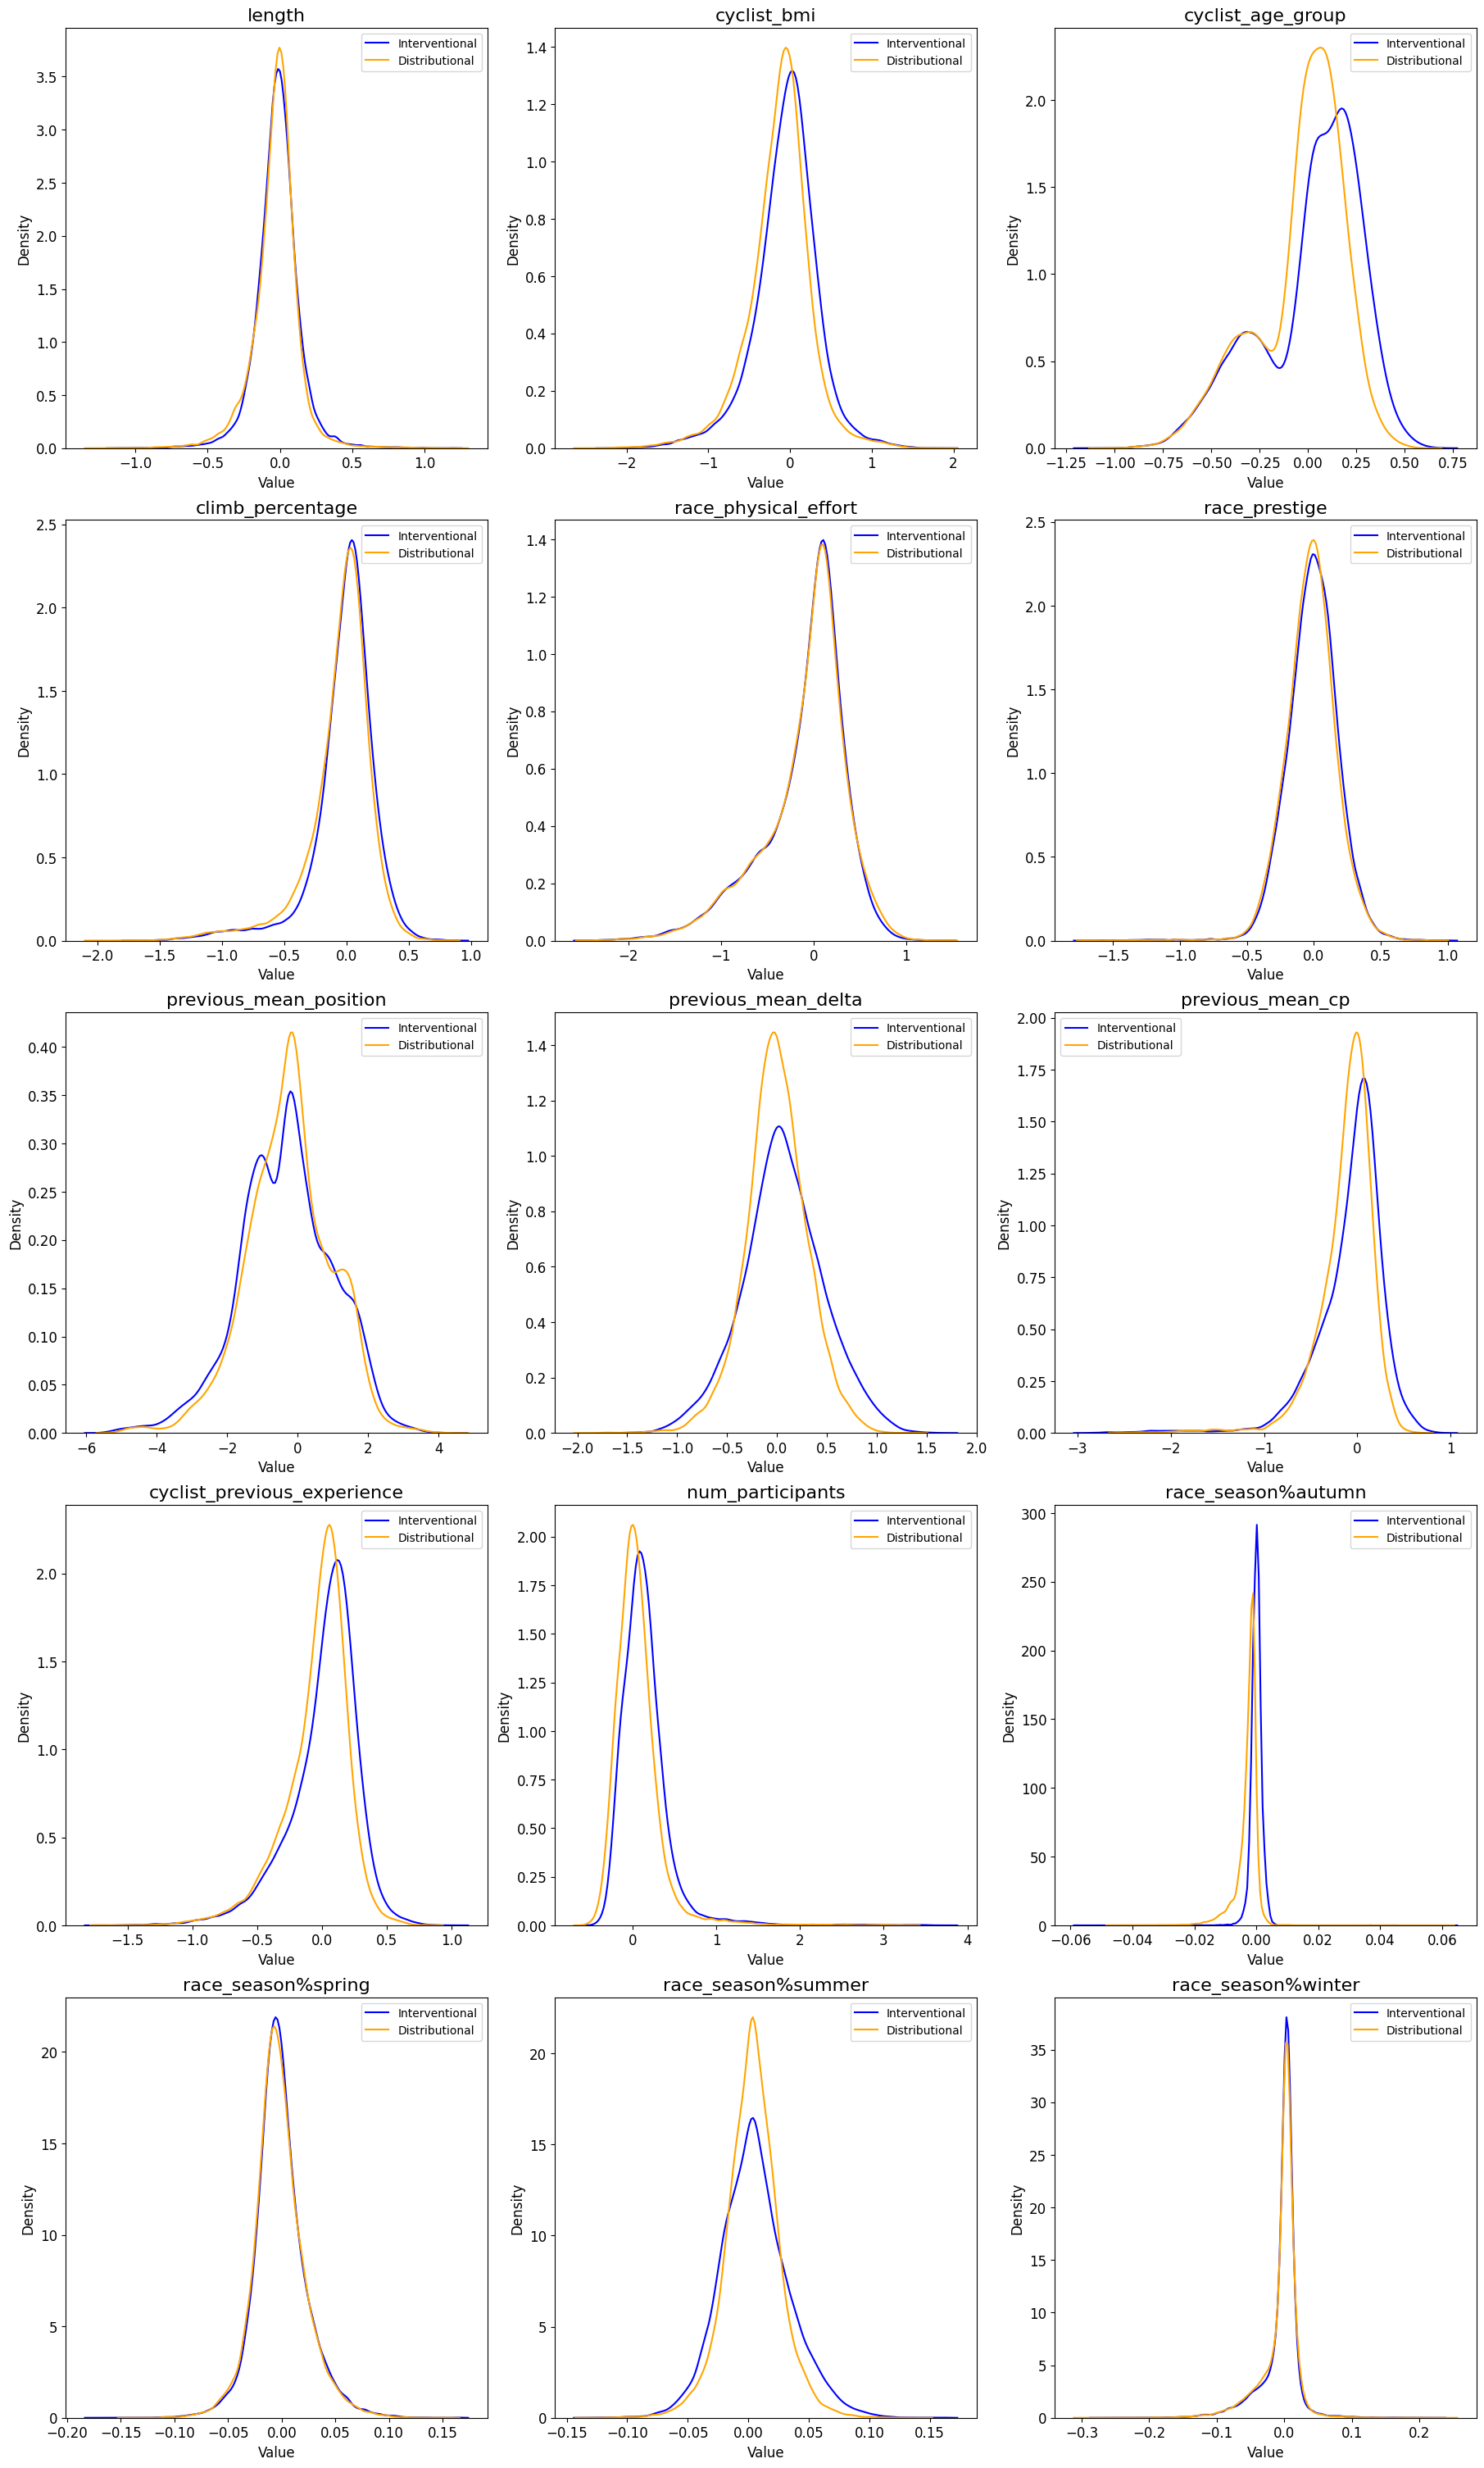

In [25]:
features = interventional_explanations_df.columns  


num_features = len(features)


plots_per_row = 3
num_rows = (num_features + plots_per_row - 1) // plots_per_row 


fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(18, 6 * num_rows), constrained_layout=True)


axes = axes.flatten()

for i, feature in enumerate(features):
    sb.kdeplot(interventional_explanations_df[feature], label='Interventional', color='blue', ax=axes[i])
    sb.kdeplot(distributional_explanations_df[feature], label='Distributional', color='orange', ax=axes[i])
    
    axes[i].set_title(f'{feature}', fontsize=16)
    axes[i].set_xlabel('Value', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=10)

    axes[i].tick_params(axis='x', labelsize=12) 
    axes[i].tick_params(axis='y', labelsize=12)  


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.show()

### Validation

In [26]:
pd.DataFrame(report)

,0,1,accuracy,macro avg,weighted avg
precision,0.944744,0.259552,0.684666,0.602148,0.853751
recall,0.675909,0.741851,0.684666,0.708880,0.684666
f1-score,0.788029,0.384558,0.684666,0.586294,0.734448
support,27446.000000,4203.000000,0.684666,31649.000000,31649.000000


Ordiniamo le feature per importanza

In [27]:
# Calculation of mean absolute feature importance
mean_absolute_importances = interventional_explanations_df.abs().mean()

# We sort the columns from the less to the most important respect to mean absolute feature importance
features_by_importance = interventional_explanations_df.columns[mean_absolute_importances.argsort()].tolist()
features_by_importance

['race_season%autumn',
 'race_season%winter',
 'race_season%spring',
 'race_season%summer',
 'length',
 'race_prestige',
 'climb_percentage',
 'cyclist_previous_experience',
 'cyclist_age_group',
 'num_participants',
 'previous_mean_cp',
 'cyclist_bmi',
 'previous_mean_delta',
 'race_physical_effort',
 'previous_mean_position']

In [28]:
random_noise = np.random.rand(test_set.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

# We corrupt the test set with different noise magnitudes
# Each corruption (different magnitude) is stored in a dict
corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_set.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

In [29]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_label, model.predict(corruption), output_dict=True)

In [30]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - report["weighted avg"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,race_season%autumn,0.1,0.734448,shap,0.000000
1,race_season%autumn,0.2,0.734448,shap,0.000000
2,race_season%autumn,0.3,0.734448,shap,0.000000
3,race_season%autumn,0.4,0.734448,shap,0.000000
4,race_season%autumn,0.5,0.734448,shap,0.000000
...,...,...,...,...,...
130,previous_mean_position,0.5,0.819526,shap,0.085077
131,previous_mean_position,0.6,0.820815,shap,0.086367
132,previous_mean_position,0.7,0.821625,shap,0.087177
133,previous_mean_position,0.8,0.820824,shap,0.086375


In [31]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                \
                                  count      mean       std       min   
feature                                                                 
climb_percentage                    9.0  0.769649  0.000798  0.767770   
cyclist_age_group                   9.0  0.734448  0.000000  0.734448   
cyclist_bmi                         9.0  0.725025  0.004742  0.718083   
cyclist_previous_experience         9.0  0.752990  0.010764  0.735537   
length                              9.0  0.734691  0.000136  0.734448   
num_participants                    9.0  0.734448  0.000000  0.734448   
previous_mean_cp                    9.0  0.759748  0.006102  0.745025   
previous_mean_delta                 9.0  0.734402  0.000092  0.734221   
previous_mean_position              9.0  0.814465  0.012958  0.782139   
race_physical_effort                9.0  0.757103  0.009456  0.738903   
race_prestige                       9.0  0.752784  0.011321  0.735710   
race_season%autumn                  9.0  0.734448  0.000000  0.734448   
race_season%spring                  9.0  0.734448  0.000000  0.734448   
race_season%summer                  9.0  0.734448  0.000000  0.734448   
race_season%winter                  9.0  0.734448  0.000000  0.734448   

                                                                     \
                                  25%       50%       75%       max   
feature                                                               
climb_percentage             0.769738  0.769887  0.770090  0.770270   
cyclist_age_group            0.734448  0.734448  0.734448  0.734448   
cyclist_bmi                  0.721454  0.725203  0.728749  0.731458   
cyclist_previous_experience  0.744712  0.757122  0.761046  0.763560   
length                       0.734654  0.734733  0.734782  0.734835   
num_participants             0.734448  0.734448  0.734448  0.734448   
previous_mean_cp             0.759762  0.762281  0.763129  0.763999   
previous_mean_delta          0.734346  0.734425  0.734451  0.734527   
previous_mean_position       0.817818  0.819819  0.820824  0.821625   
race_physical_effort         0.752727  0.761276  0.763791  0.766033   
race_prestige                0.744305  0.755942  0.761688  0.766396   
race_season%autumn           0.734448  0.734448  0.734448  0.734448   
race_season%spring           0.734448  0.734448  0.734448  0.734448   
race_season%summer           0.734448  0.734448  0.734448  0.734448   
race_season%winter           0.734448  0.734448  0.734448  0.734448   

                            difference                                \
                                 count      mean       std       min   
feature                                                                
climb_percentage                   9.0  0.035200  0.000798  0.033322   
cyclist_age_group                  9.0  0.000000  0.000000  0.000000   
cyclist_bmi                        9.0 -0.009423  0.004742 -0.016365   
cyclist_previous_experience        9.0  0.018542  0.010764  0.001089   
length                             9.0  0.000243  0.000136  0.000000   
num_participants                   9.0  0.000000  0.000000  0.000000   
previous_mean_cp                   9.0  0.025300  0.006102  0.010576   
previous_mean_delta                9.0 -0.000046  0.000092 -0.000227   
previous_mean_position             9.0  0.080017  0.012958  0.047690   
race_physical_effort               9.0  0.022655  0.009456  0.004454   
race_prestige                      9.0  0.018336  0.011321  0.001261   
race_season%autumn                 9.0  0.000000  0.000000  0.000000   
race_season%spring                 9.0  0.000000  0.000000  0.000000   
race_season%summer                 9.0  0.000000  0.000000  0.000000   
race_season%winter                 9.0  0.000000  0.000000  0.000000   

                                                                     
                                  25%       50%       75%       max

In [32]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                    15.0  0.740808  0.014445  0.731458  0.734448  0.734448   
0.2                    15.0  0.744044  0.020128  0.730536  0.734448  0.734476   
0.3                    15.0  0.746267  0.022887  0.728749  0.734448  0.734527   
0.4                    15.0  0.747582  0.023875  0.726636  0.734448  0.734448   
0.5                    15.0  0.748477  0.024050  0.725203  0.734448  0.734451   
0.6                    15.0  0.748957  0.024690  0.723368  0.734448  0.734448   
0.7                    15.0  0.749246  0.025196  0.721454  0.734448  0.734448   
0.8                    15.0  0.749560  0.025459  0.719739  0.734448  0.734448   
0.9                    15.0  0.749587  0.025552  0.718083  0.734448  0.734448   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.737306  0.782139       15.0  0.006360  0.014445 -0.002991   
0.2              0.742616  0.806746       15.0  0.009596  0.020128 -0.003912   
0.3              0.748720  0.817818       15.0  0.011818  0.022887 -0.005700   
0.4              0.754345  0.820877       15.0  0.013133  0.023875 -0.007813   
0.5              0.759199  0.819526       15.0  0.014029  0.024050 -0.009246   
0.6              0.761704  0.820815       15.0  0.014509  0.024690 -0.011081   
0.7              0.762408  0.821625       15.0  0.014798  0.025196 -0.012994   
0.8              0.764006  0.820824       15.0  0.015112  0.025459 -0.014710   
0.9              0.765016  0.819819       15.0  0.015139  0.025552 -0.016365   

                                                    
                 25%       50%       75%       max  
noise_magnitude                                     
0.1              0.0  0.000000  0.002858  0.047690  
0.2              0.0  0.000028  0.008167  0.072298  
0.3              0.0  0.000079  0.014271  0.083370  
0.4              0.0  0.000000  0.019897  0.086429  
0.5              0.0  0.000002  0.024751  0.085077  
0.6              0.0  0.000000  0.027255  0.086367  
0.7              0.0  0.000000  0.027960  0.087177  
0.8              0.0  0.000000  0.029557  0.086375  
0.9              0.0  0.000000  0.030568  0.085371

In [33]:
#TODO Additive Addition
#TODO Additive Removal

In [34]:
removed_feature_results = []

for feature in features_by_importance:  # Ordine di importanza delle feature
    # Filtra il dataset per rimuovere la feature corrente
    reduced_train_data = dev_set.drop(columns=[feature])
    reduced_test_data = test_set.drop(columns=[feature])

    # Riaddestra il modello da zero
    model.fit(reduced_train_data, dev_label)

    # Valuta il modello sul dataset di test ridotto
    predictions = model.predict(reduced_test_data)
    report = classification_report(test_label, predictions, output_dict=True)

    # Salva i risultati
    removed_feature_results.append({
        "feature_removed": feature,
        "performance": report["weighted avg"]["f1-score"]  # Usa la metrica desiderata
    })

# Converte i risultati in un dataframe per analisi
removed_feature_results_df = pd.DataFrame(removed_feature_results)

In [35]:
removed_feature_results_df.sort_values(by="performance", ascending=False)

,feature_removed,performance
14,previous_mean_position,0.765329
12,previous_mean_delta,0.741805
9,num_participants,0.736727
6,climb_percentage,0.736048
3,race_season%summer,0.735189
13,race_physical_effort,0.733401
1,race_season%winter,0.733104
7,cyclist_previous_experience,0.733000
0,race_season%autumn,0.732700
4,length,0.732638


In [36]:
added_feature_results = []

# Inizia con un dataset vuoto (o con una base minimale, se necessario)
base_train_data = pd.DataFrame(index=dev_set.index)
base_test_data = pd.DataFrame(index=test_set.index)

for feature in features_by_importance:  # Ordine di importanza delle feature
    # Aggiungi la feature corrente al dataset base
    base_train_data[feature] = dev_set[feature]
    base_test_data[feature] = test_set[feature]

    # Riaddestra il modello con le feature attuali
    model.fit(base_train_data, dev_label)

    # Valuta il modello sul dataset di test aggiornato
    predictions = model.predict(base_test_data)
    report = classification_report(test_label, predictions, output_dict=True)

    # Salva i risultati
    added_feature_results.append({
        "feature_added": feature,
        "performance": report["weighted avg"]["f1-score"]  # Usa la metrica desiderata
    })

# Converte i risultati in un dataframe per analisi
added_feature_results_df = pd.DataFrame(added_feature_results)

In [37]:
added_feature_results_df.sort_values(by="performance", ascending=False)

,feature_added,performance
0,race_season%autumn,0.805270
13,race_physical_effort,0.764884
12,previous_mean_delta,0.763899
11,cyclist_bmi,0.745775
14,previous_mean_position,0.733588
1,race_season%winter,0.711350
10,previous_mean_cp,0.703529
9,num_participants,0.650600
8,cyclist_age_group,0.612322
5,race_prestige,0.573578


## Lime

In [41]:
set_visualize_provider(InlineProvider())

In [51]:
# possiamo limitarci ai primi 100 dati per ridurre il costo compiutazionale pur ottenendo risultati interessanti

# Define the feature order expected by the model
expected_order = ['race_season%autumn', 'race_season%winter', 'race_season%spring', 
                  'race_season%summer', 'length', 'race_prestige', 'climb_percentage', 
                  'cyclist_previous_experience', 'cyclist_age_group', 'num_participants', 
                  'previous_mean_cp', 'cyclist_bmi', 'previous_mean_delta', 
                  'race_physical_effort', 'previous_mean_position']

# Reorder columns of dev_set accordingly
dev_set = dev_set[expected_order]

explanation_algorithm = LimeTabular(model, dev_set, feature_names=expected_order)
explanations["lime"] = np.array([np.array(e["scores"])
                                    for e in tqdm(explanation_algorithm.explain_local(dev_set[:100], dev_label[:100])._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 482103.91it/s]


### Validation

In [53]:
metric = "f1-score"
corruption_validation_lime = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime["difference"] = corruption_validation_lime["performance"] - report["weighted avg"][metric]

corruption_validation = pd.concat((corruption_validation, corruption_validation_lime))
corruption_validation_lime

,feature,noise_magnitude,performance,algorithm,difference
0,race_season%autumn,0.1,0.734448,lime,0.000861
1,race_season%autumn,0.2,0.734448,lime,0.000861
2,race_season%autumn,0.3,0.734448,lime,0.000861
3,race_season%autumn,0.4,0.734448,lime,0.000861
4,race_season%autumn,0.5,0.734448,lime,0.000861
...,...,...,...,...,...
130,previous_mean_position,0.5,0.819526,lime,0.085938
131,previous_mean_position,0.6,0.820815,lime,0.087227
132,previous_mean_position,0.7,0.821625,lime,0.088037
133,previous_mean_position,0.8,0.820824,lime,0.087236


In [54]:
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,race_season%autumn,0.1,0.734448,shap,0.000000
1,race_season%autumn,0.2,0.734448,shap,0.000000
2,race_season%autumn,0.3,0.734448,shap,0.000000
3,race_season%autumn,0.4,0.734448,shap,0.000000
4,race_season%autumn,0.5,0.734448,shap,0.000000
...,...,...,...,...,...
130,previous_mean_position,0.5,0.819526,lime,0.085938
131,previous_mean_position,0.6,0.820815,lime,0.087227
132,previous_mean_position,0.7,0.821625,lime,0.088037
133,previous_mean_position,0.8,0.820824,lime,0.087236


## Lore

In [ ]:
explanation_algorithm = LoreTabularExplainer(model)
configuration = {
    "neigh_type": "rndgen", # metodo di generazione del dataset locale (in questo caso random)
    "size": 1000, # dimensione del dataset locale generato
    "ocr": 0.1, # probabilità di "cambiamento" di una feature durante la perturbazione
    "ngen": 100 # numero di generazioni 
}

lore_train_data = pd.concat((dev_set, dev_label), axis="columns")
explanation_algorithm.fit(lore_train_data, "label", config=configuration)
explanation = explanation_algorithm.explain(dev_set.iloc[0].values)

In [61]:
# restituisce regole decisionali che descrivono come il modello ha preso la decisione per l'istanza specifica
explanation.getRules()

{'premise': [{'att': 'previous_mean_position',
   'op': '<=',
   'thr': 0.4752162843942642,
   'is_continuous': True},
  {'att': 'previous_mean_position',
   'op': '>',
   'thr': 0.41609349846839905,
   'is_continuous': True},
  {'att': 'previous_mean_cp',
   'op': '<=',
   'thr': 0.0005422874237410724,
   'is_continuous': True},
  {'att': 'cyclist_bmi',
   'op': '<=',
   'thr': 23.964348793029785,
   'is_continuous': True},
  {'att': 'cyclist_bmi',
   'op': '>',
   'thr': 20.553513526916504,
   'is_continuous': True},
  {'att': 'cyclist_previous_experience',
   'op': '>',
   'thr': 0.01318426989018917,
   'is_continuous': True},
  {'att': 'previous_mean_delta',
   'op': '<=',
   'thr': 522.5713195800781,
   'is_continuous': True},
  {'att': 'num_participants',
   'op': '<=',
   'thr': 163.5,
   'is_continuous': True}],
 'cons': 0,
 'class_name': 'label'}

In [62]:
# genera le regole controfattuali -> condizioni che se cambiate avrebbero portate ad una predizione diversa
explanation.getCounterfactualRules()

[{'premise': [{'att': 'previous_mean_position',
    'op': '<=',
    'thr': 0.5976776480674744,
    'is_continuous': True},
   {'att': 'previous_mean_position',
    'op': '>',
    'thr': 0.4752162843942642,
    'is_continuous': True},
   {'att': 'num_participants',
    'op': '<=',
    'thr': 150.5,
    'is_continuous': True},
   {'att': 'previous_mean_cp',
    'op': '>',
    'thr': 0.0005846558487974107,
    'is_continuous': True},
   {'att': 'race_physical_effort',
    'op': '>',
    'thr': 0.012058905325829983,
    'is_continuous': True},
   {'att': 'cyclist_previous_experience',
    'op': '<=',
    'thr': 0.05208740383386612,
    'is_continuous': True},
   {'att': 'length', 'op': '>', 'thr': 182.0, 'is_continuous': True},
   {'att': 'race_prestige',
    'op': '<=',
    'thr': 0.09187233820557594,
    'is_continuous': True}],
  'cons': 1,
  'class_name': 'label'},
 {'premise': [{'att': 'previous_mean_position',
    'op': '<=',
    'thr': 0.4752162843942642,
    'is_continuous': True},

In [63]:
explanation.plotRules()

In [64]:
explanation.expDict["fidelity"]

0.9817307377218508

In [65]:
explanation.expDict.keys()

dict_keys(['bb_pred', 'dt_pred', 'rule', 'crules', 'deltas', 'fidelity', 'dt'])